In this project, we will analyze a plan in order to extract a navigation map, then we will
implement and compare several ways to find the shortest path between two points in the
plan. Finally, we will use Pattern Matching to find way points defining a tour.

# Load images

In [68]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Any

In [69]:
images_name = os.listdir(os.path.join(os.getcwd(), "images"))

images = {image_name[:image_name.index(".")] : cv2.imread(os.path.join(os.getcwd(), "images", image_name)) for image_name in images_name}
images = { img : cv2.cvtColor(images[img], cv2.COLOR_BGR2RGB) for img in images}
images.keys()

dict_keys(['outdoorMap', 'pattern4', 'pattern2', 'pattern3', 'pattern1'])

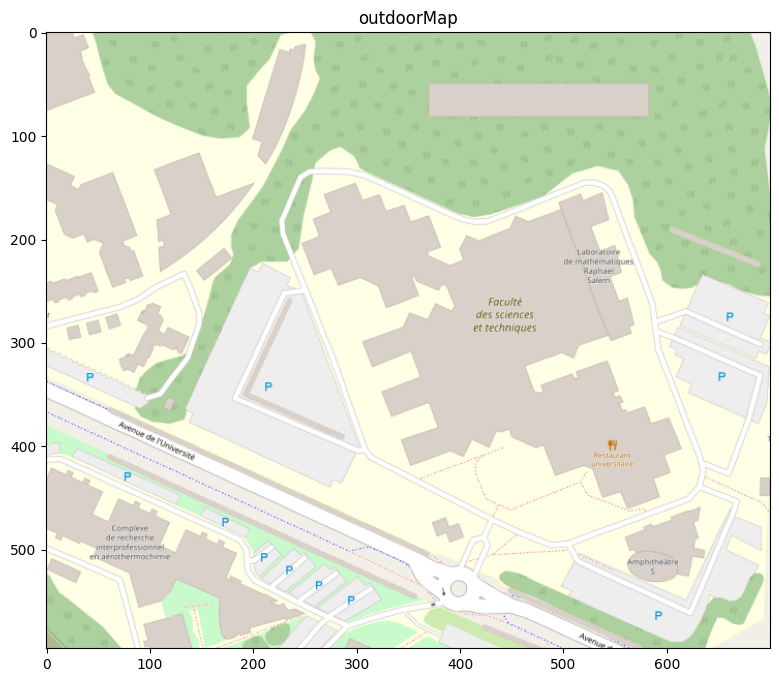

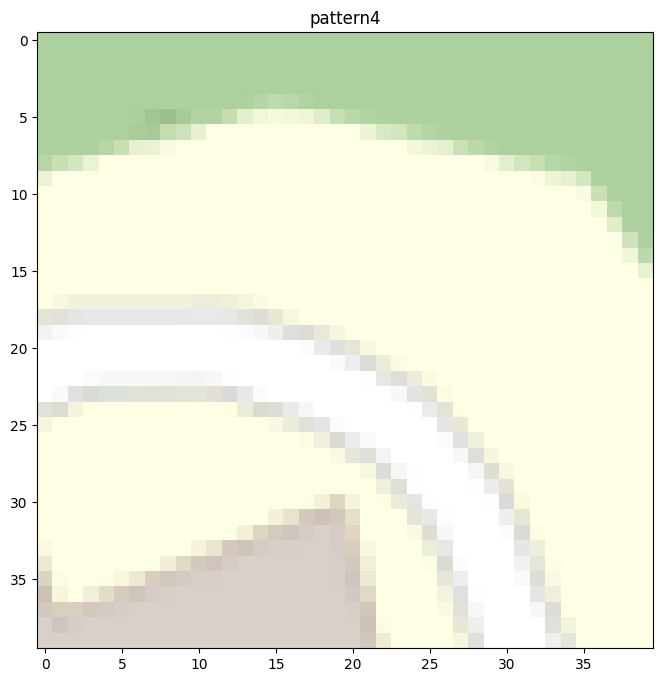

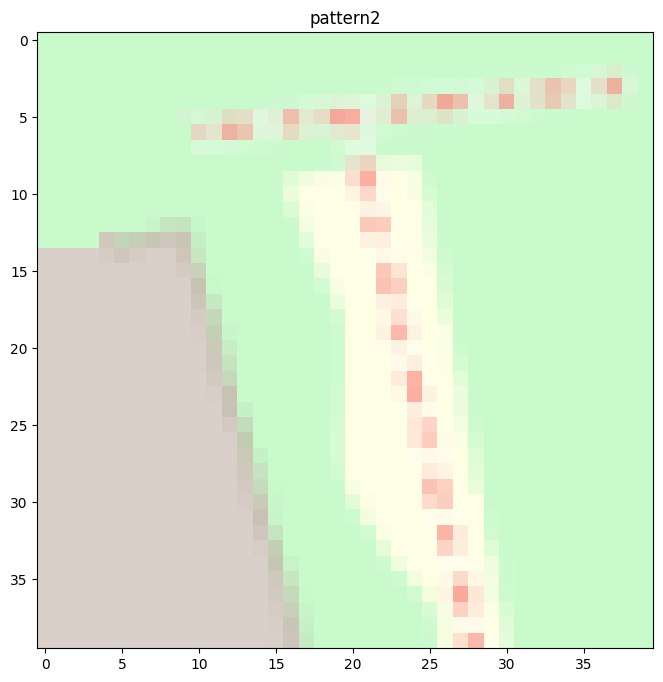

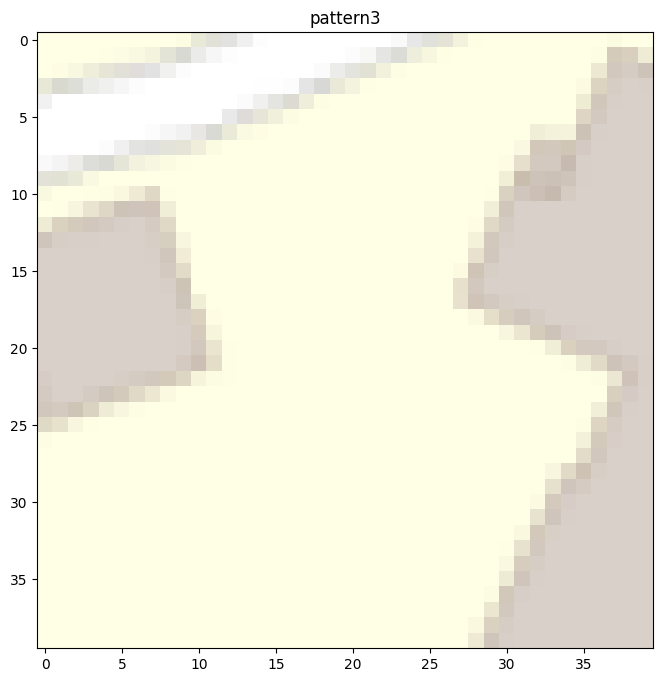

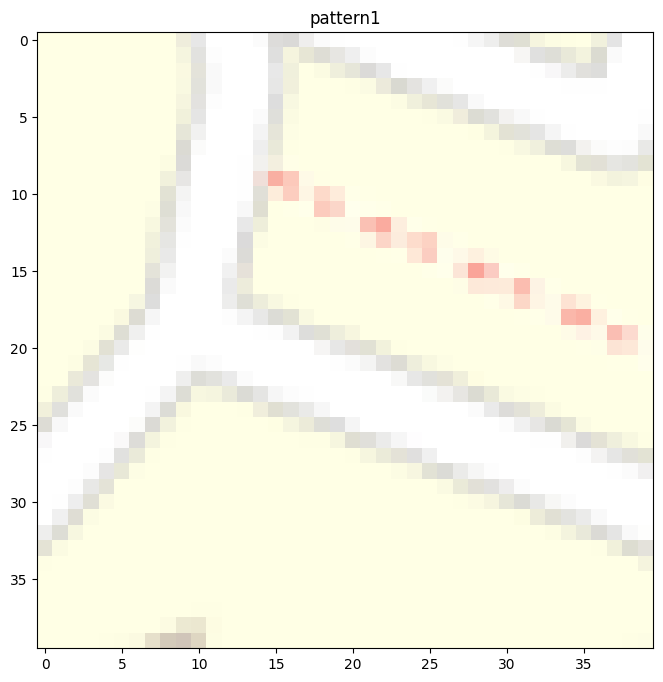

In [70]:
for img in images:
    plt.figure(figsize=(10, 8))
    plt.imshow(images[img])
    plt.title(img)

In [71]:
def distance(a , b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def foor_accessible_neighbors(point, thresholded_map, wall_pixel):
    xMax, yMax = thresholded_map.shape[:2]
    neighboors = [(point[0] + i, point[1] ) for i in [-1, 1]]
    neighboors += [(point[0] , point[1] + i) for i in [-1, 1]]
    neighboors = [neighboor for neighboor in neighboors if ( 0<= neighboor[0]< xMax and 0<= neighboor[1]< yMax)]
    for neighboor in neighboors:
        if not np.all(thresholded_map[neighboor] == wall_pixel, axis=-1):
            yield neighboor
    

def eight_accessible_neighbors(point, thresholded_map, wall_pixel):
    xMax, yMax = thresholded_map.shape[:2]
    neighboors = [(point[0] + i, point[1] + j) for i in [-1,0, 1] for j in [-1,0, 1] if i*j + i+j != 0] 
    # this condition mean i != 0 and j!= 0

    neighboors = [neighboor for neighboor in neighboors if ( 0<= neighboor[0]< xMax and 0<= neighboor[1]< yMax)]
    for neighboor in neighboors:
        if not np.all(thresholded_map[neighboor] == wall_pixel, axis=-1):
            yield neighboor

In [72]:
def draw_path(map_image, point_list, path_color):
    img = map_image.copy()
    for point in point_list:
        img[point] = path_color 
    return img
    

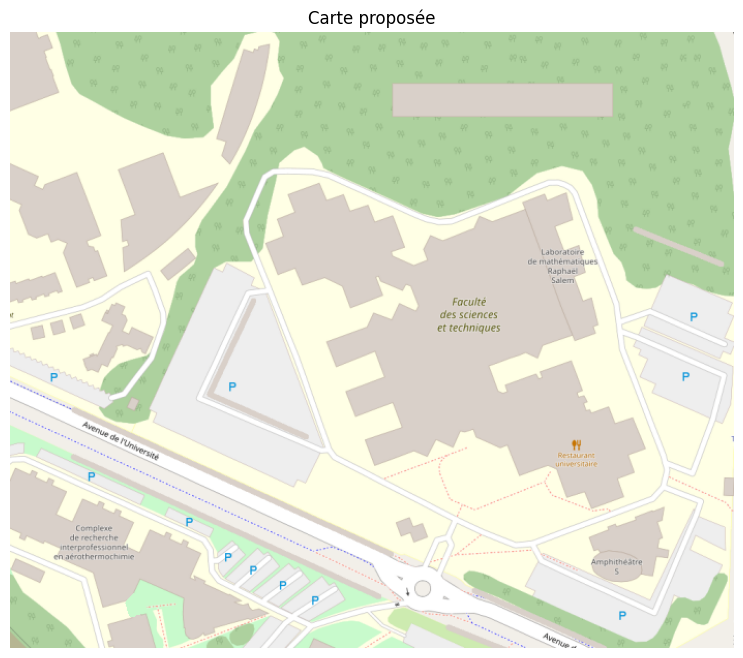

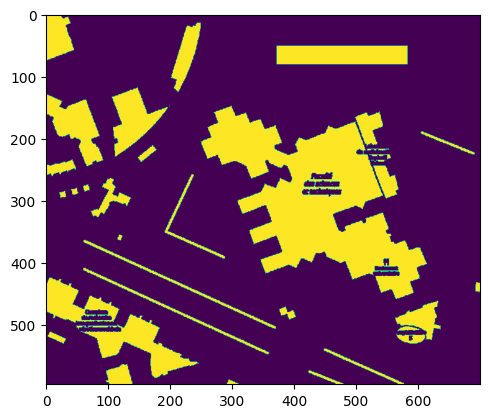

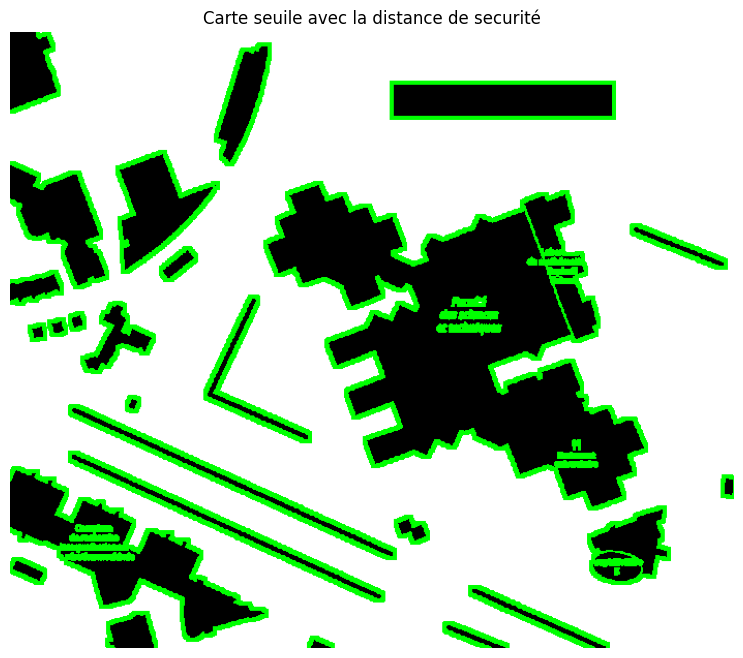

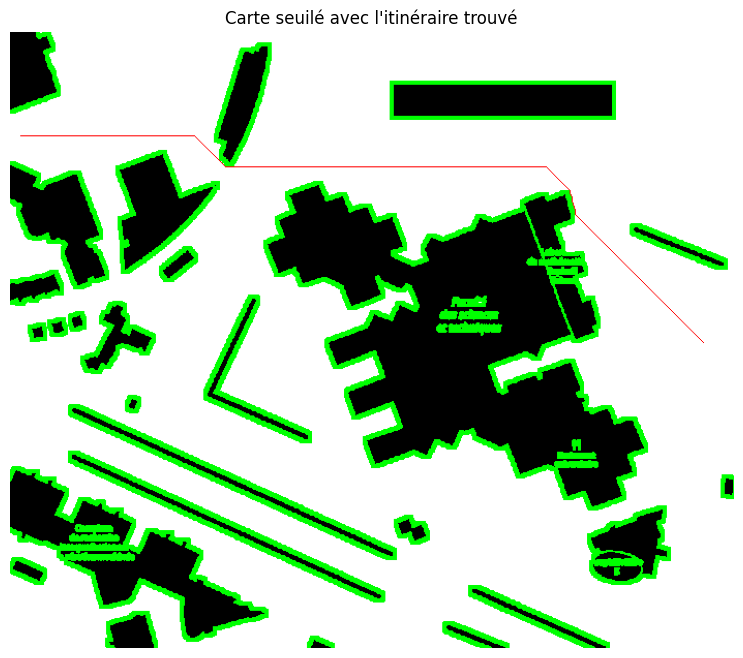

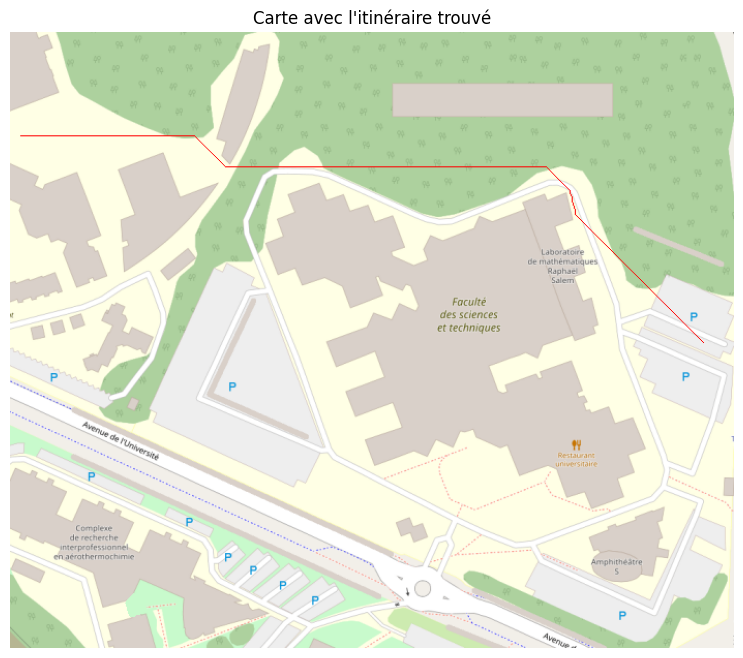

In [73]:



def find_path(map_image : np.ndarray,
            start_point : tuple, end_point : tuple, 
            obstacle_pixel = [[217, 208, 201]],   wall_pixel : List = [0, 255, 0],
            path_color : List = [255, 0, 0], # le chemin en rouge
            sortpoint = False,
            weight = 1, # à modifier si on veut utiliser l"algorithme de recherche ponderé
            verbose = False
            ):
    if verbose:
        plt.figure(figsize=(10, 8))
        plt.title("Carte proposée")
        plt.axis("off")
        plt.imshow(map_image)

    thresholded_map = map_image.copy()
    mask = np.zeros(map_image.shape[:2]) == 1
    for pixel in obstacle_pixel:
        mask = mask | np.all(map_image == pixel,axis=-1)

    #np.all(outdor_map == obstacle_pixel,axis=-1)
    if verbose:
        plt.figure()
        plt.imshow(mask)
    thresholded_map[mask] = 0
    thresholded_map[~mask] = 255

    mask = mask.astype(np.int8)*255
    structurant = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

    # on applique une dilatation à notre mask puis on fait la difference pour avoir la distance de securité avec les mure
    dilated_mask = cv2.dilate(mask, kernel=structurant)
    security_distance = dilated_mask & ~mask
    thresholded_map[security_distance == 255] = wall_pixel

    if verbose:
        plt.figure(figsize=(10, 8))
        plt.title("Carte seuile avec la distance de securité")
        plt.axis("off")
        plt.imshow(thresholded_map)


    # nous allons travailler sur le carte suillé avec les distance de securité
    valid_point = lambda p : 0<= p[0] < thresholded_map.shape[0] and  0 <= p[1] < thresholded_map.shape[1]
    if not (valid_point(start_point) and valid_point(end_point)):
        print("le point de depart ou d'arrive sont invalide")
        return

    INF = 10*distance((0,0), map_image.shape[:2])   #10  la diagonal de l'image

    distance_matrix = INF*np.ones(thresholded_map.shape[:2])
    distance_matrix[start_point] = 0
    list_point = [start_point]


    while list_point and end_point not in list_point:
        p0 = list_point[0]
        for neighbor in foor_accessible_neighbors(p0, thresholded_map, wall_pixel):
            if distance_matrix[p0] + 1 < distance_matrix[neighbor]:
                distance_matrix[neighbor] =  distance_matrix[p0] + 1
                list_point.append(neighbor)
        list_point.pop(0)
        if sortpoint:
            list_point.sort(key=lambda p : distance_matrix[p])

    if distance_matrix[end_point] == INF:
        print('Destination innaccessible') 
        return


    p0 = end_point
    path = [p0]
    while p0 != start_point:
        p0 = min(list(eight_accessible_neighbors(p0, thresholded_map, wall_pixel)), key=lambda p: distance_matrix[p])
        path.append(p0)

    

    if verbose:
        for point in path:
            thresholded_map[point] = path_color 

        plt.figure(figsize=(10, 8))
        plt.title("Carte seuilé avec l'itinéraire trouvé")
        plt.axis("off")
        plt.imshow(thresholded_map)


    if verbose:
        plt.figure(figsize=(10, 8))
        map_with_path = map_image.copy()
        for point in path:
            map_with_path[point] = path_color

    
        plt.title("Carte avec l'itinéraire trouvé")
        plt.axis("off")
        plt.imshow(map_with_path)

    return path, distance_matrix[end_point]

image = images["outdoorMap"]
obstable = [[217, 208, 201]]
point_depart= (100, 10)
point_arrive = (300, 670)

_ = find_path(image, point_depart, point_arrive, obstacle_pixel=obstable, verbose=True)

# chemin entre l'entrée principal et la bibliotheque 

## Graphe Transversal

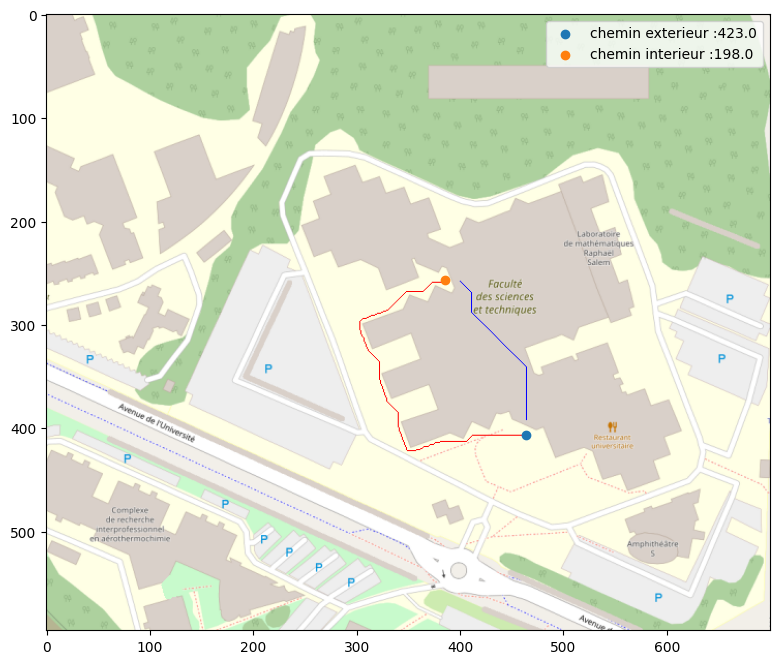

In [74]:
entree_exterieur = (407 , 464)
bu_exterieur = ( 257, 385)

entree_interieur = ( 392, 464)
bu_interieur = ( 258,400 )


map = images["outdoorMap"]
out_path, out_distance = find_path(map,start_point=entree_exterieur, end_point=bu_exterieur)
in_path, in_distance = find_path(map,start_point=entree_interieur, end_point=bu_interieur)

map = draw_path(map, out_path, [255, 0, 0])
map = draw_path(map, in_path, [0, 0, 255])

plt.figure(figsize=(10, 8))
plt.scatter([entree_exterieur[1]], [entree_exterieur[0]], label=f"chemin exterieur :{out_distance}")
plt.scatter([bu_exterieur[1]], [bu_exterieur[0]], label=f"chemin interieur :{in_distance}")
plt.legend()
plt.imshow(map)
plt.show()

## Algorythme A*

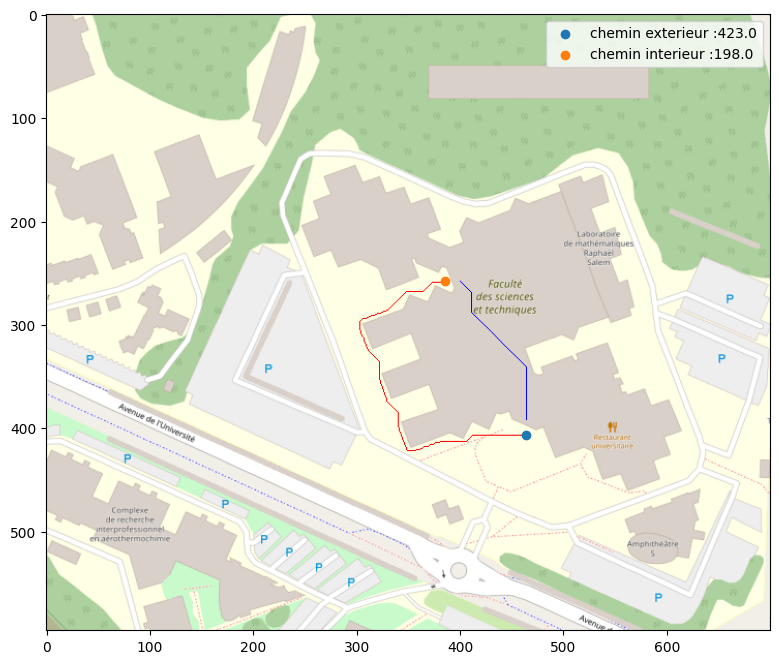

In [75]:
map = images["outdoorMap"]
out_path, out_distance = find_path(map,start_point=entree_exterieur, end_point=bu_exterieur, sortpoint=True)
in_path, in_distance = find_path(map,start_point=entree_interieur, end_point=bu_interieur, sortpoint=True)

map = draw_path(map, out_path, [255, 0, 0])
map = draw_path(map, in_path, [0, 0, 255])

plt.figure(figsize=(10, 8))
plt.scatter([entree_exterieur[1]], [entree_exterieur[0]], label=f"chemin exterieur :{out_distance}")
plt.scatter([bu_exterieur[1]], [bu_interieur[0]], label=f"chemin interieur :{in_distance}")
plt.imshow(map)
plt.legend()

# Chemin entre le rondpoint et la porte de la bibliotheque par l'exterieur et par l'interieur

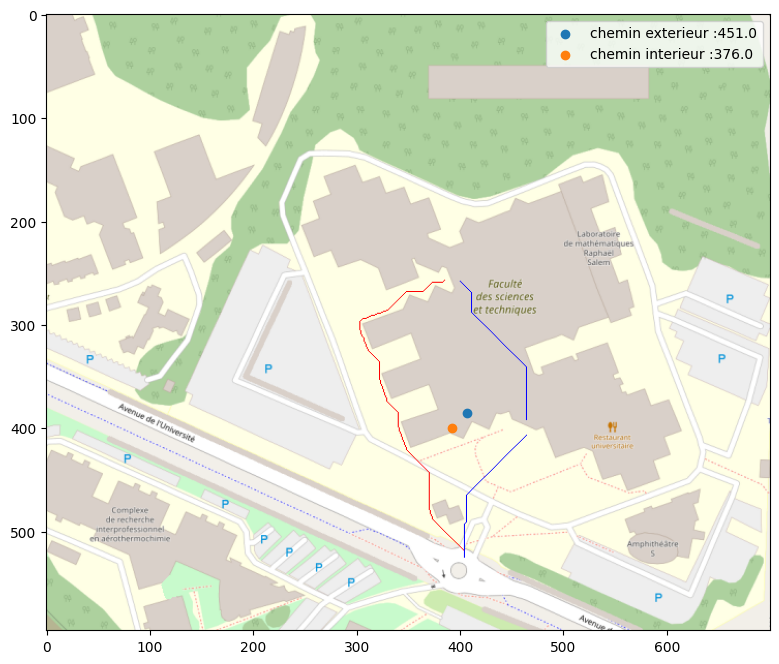

In [76]:
map = images["outdoorMap"]
rond_point = (525, 404)


out_path, out_distance = find_path(map,start_point=rond_point, end_point=bu_exterieur, sortpoint=True)
in_path1, in_distance1 = find_path(map,start_point=rond_point, end_point=entree_exterieur, sortpoint=True)
in_path2, in_distance2 = find_path(map,start_point=entree_interieur, end_point=bu_interieur, sortpoint=True)


map = draw_path(map, out_path, [255, 0, 0])
map = draw_path(map, in_path1, [0, 0, 255])
map = draw_path(map, in_path2, [0, 0, 255])



plt.figure(figsize=(10, 8))
plt.scatter([entree_exterieur[0]], [bu_exterieur[1]], label=f"chemin exterieur :{out_distance}")
plt.scatter([entree_interieur[0]], [bu_interieur[1]], label=f"chemin interieur :{in_distance1 + in_distance2}")
plt.imshow(map)
plt.legend()

Passer par l'interieur de l'UFR est plus rapide pour aller a la bibliotheque que passer par l'interieur

# le chemin le plus rapide en cas d'alarme d'incendie avec evacuation

In [77]:
array_to_hex  = lambda color : "#" + "".join ([str(hex(i))[2:] for i in color])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


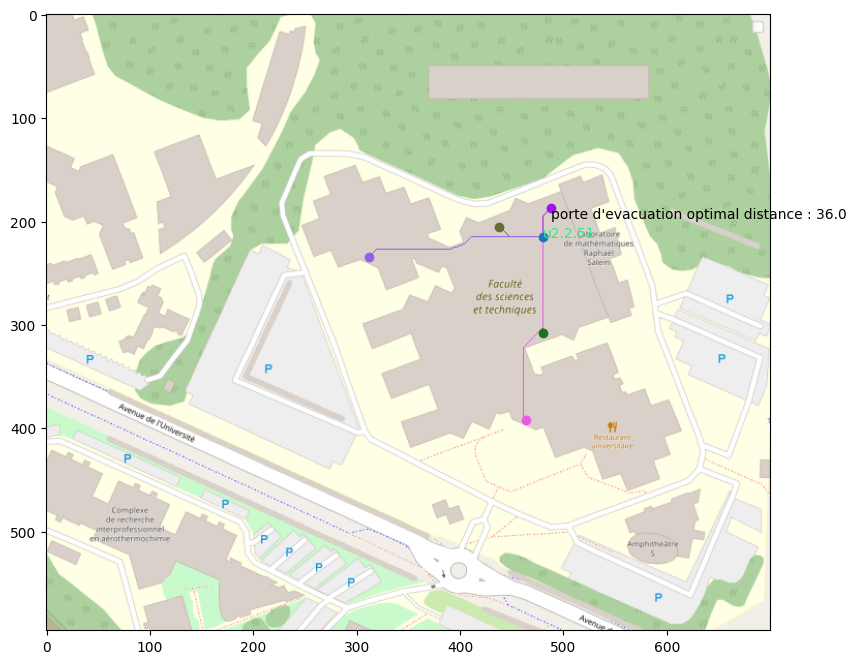

In [87]:
map = images["outdoorMap"]
u2_2_51 = (215, 480)

gate_1 = (205, 438)
gate_2 = (187, 488)

gate_3 = (308, 480)
gate_4 = (234, 312)
gate_5 = (392, 464)

evacuation_gate = [gate_1, gate_2, gate_3, gate_4, gate_5]

path_and_distances = [find_path(map, start_point=u2_2_51, end_point=gate) for gate in evacuation_gate]

plt.figure(figsize=(10, 8))
color = np.random.randint(10, 256, (3,))
plt.scatter(u2_2_51[1], u2_2_51[0])
plt.text(u2_2_51[1], u2_2_51[0], "u2.2.51", color=array_to_hex(color))
min_distance = (9, 1000000)
for i,(path, dist) in enumerate(path_and_distances):
    porte = evacuation_gate[i]
    color = np.random.randint(10, 256, (3,))
    plt.scatter(porte[1], porte[0], color=array_to_hex(color))
    if dist <= min_distance[1]:
        min_distance = (i, dist)
    map = draw_path(map, path, path_color=color)


porte_optimal = evacuation_gate[min_distance[0]]
plt.text(porte_optimal[1], porte_optimal[0] - 10,  f"porte d'evacuation optimal distance : {min_distance[1]}")

#plt.figure(figsize=(10, 8))
plt.imshow(map)
plt.legend()
plt.show()